In [ ]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
from scipy.stats import ks_2samp
from scipy.special import binom
from pyEulerCurves import ECC_from_pointcloud
from bifiltration_utils import wasserstein_distance_ECP, bottleneck_distance_ECP
import math
from scipy.interpolate import interp1d

#from curlyBrace import curlyBrace
#%matplotlib widget

In [ ]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (np.sqrt(simplices[i][1])<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

def sampled_bc_alpha(pointcloud, n_samples, max_filt_val, dim=0):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    st.compute_persistence()
    barcode = st.persistence_intervals_in_dimension(dim)
    bc = representations.BettiCurve(predefined_grid=np.linspace(0,max_filt_val,n_samples))
    return bc.fit_transform([barcode])[0]
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs
def ecc_distance(samples1, samples2, n_samples, max_filt_val):
    ECCs1 = get_ecc(samples1, n_samples = n_samples, max_filt_val = max_filt_val)
    ECCs2 = get_ecc(samples2, n_samples = n_samples, max_filt_val = max_filt_val)
    #dists = paired_distances(ECCs1,ECCs2, n_jobs=-1, metric = spdists.chebyshev)
    dists = np.maximum(ECCs1-ECCs2)+np.maximum(ECCs2-ECCs1)
    return dists
    #dists = dists *(max_filt_val/(n_samples-1))
    #return dists.flatten()
def gen_rv(rv, dim, N, n_samples):

    return [N**(1/dim)*np.array([rv.rvs(N) for _ in range(dim)]).T for i in range(n_samples)]

def eecc(dim, n, n_itereations,rv=st.uniform()):
    r=np.linspace(0,2,1024)
    pointclouds = gen_rv(rv,dim,n,n_itereations)
    eccs = get_ecc(pointclouds,len(r),r[-1])
    avg_unif_ecc_fn  = interp1d(r,np.mean(eccs,axis=0)/n)
    return avg_unif_ecc_fn


In [ ]:
omega = [math.pi**(d/2)/math.gamma(d/2 + 1) for d in range(5)]
omega

[1.0,
 1.9999999999999998,
 3.141592653589793,
 4.1887902047863905,
 4.934802200544679]

In [15]:
n=10000
dim=2
eecc_dim = eecc(dim,n,10,rv=st.mul())

  0%|          | 0/10 [00:00<?, ?it/s]

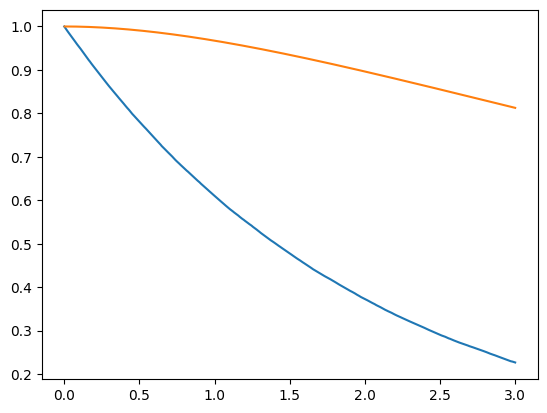

In [20]:
r=np.linspace(0,2,1024)
lmbd = np.linspace(0,3,1024)

f,ax = plt.subplots()
ax.plot(lmbd,eecc_dim((lmbd)**(1/dim)))
#ax.plot(lmbd,np.exp(-omega[dim]*lmbd)*(1 - 4*np.pi*lmbd + 1/6*np.pi**4*lmbd**2))
ax.plot(lmbd[1:],(4-np.exp(-0.5*lmbd[1:])*(lmbd[1:]+4))/lmbd[1:])
plt.show()

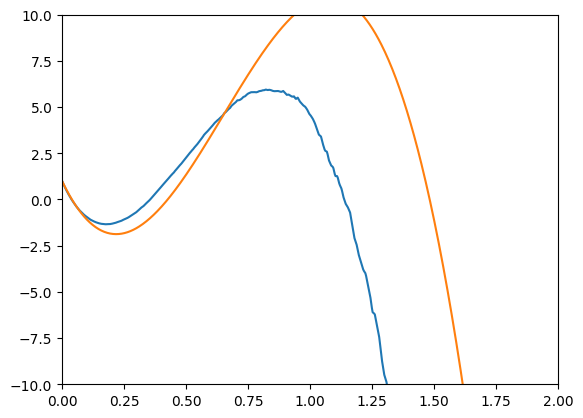

In [204]:
f,ax = plt.subplots()
ax.plot(lmbd,eecc_dim((lmbd)**(1/dim))/np.exp(-omega[dim]*lmbd))
ax.plot(lmbd,1 - 9*np.pi*lmbd +0.8*np.pi**4*lmbd**2-np.pi**9/745*lmbd**3)
#ax.plot(lmbd,(1 - 4*np.pi*lmbd + 1/6*np.pi**4*lmbd**2))
ax.set_xlim((0,2))
ax.set_ylim((-10,10))

plt.show()

In [151]:
n_evals = 32
p=np.polyfit(lmbd[:n_evals],eecc_dim((lmbd[:n_evals])**(1/dim))/np.exp(-omega[dim]*lmbd[:n_evals]),deg=1)
print(p)
print(p/np.pi)

[-20.38611302   0.85416869]
[-6.48910131  0.27189034]


In [188]:
polyvals = eecc_dim((lmbd[:n_evals])**(1/dim))/np.exp(-omega[dim]*lmbd[:n_evals])
print(1/(polyvals[:-1]-polyvals[1:]))

[10.66169814 11.33820094 11.61507239 11.90128483 12.58563877 12.40589016
 13.15975293 13.91873026 14.09724425 14.52249872 14.32640342 15.4049301
 15.36133084 16.17927461 16.82753809 17.68016174 17.37236028 17.92006795
 18.69549359 18.9317492  20.42746997 20.81929684 20.89004467 21.74758071
 25.11679874 24.50352103 24.94336669 25.25909953 26.50373685 28.19336104
 28.60843114]


In [201]:
np.pi**9/40
#6/7

745.227483336155